In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from random import sample
import pickle
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

## Functions

In [2]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [3]:
def predict_evaluate(prediction, true, graphName = 'Energy Usage Prediction', showplots=False, verticalX=None):
    
    diff = [abs(prediction[i]-true[i]) for i in range(len(prediction))]
    
    mape = mean_absolute_percentage_error(true, prediction)
    mae = mean_absolute_error(true, prediction)
    maxae = max(diff)
    mse = mean_squared_error(true, prediction)
    
    if showplots:
        resultingPlot = plt.figure(figsize=(25,10))
        plt.plot(true, color='red', label='Original Usage')
        plt.plot(prediction, color='blue', label='Predicted Usage')
        #plt.plot(diff, color='green', label='Error')
        
        if verticalX is not None:
            plt.axvline(x=verticalX, color = "green")

        plt.title(graphName)
        plt.ylabel('kW')
        plt.legend()
        plt.show()
        plt.savefig(graphName + ".png")
        
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
    
    #return {"name":graphName, "resultingPlot": resultingPlot, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}
    return mae

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=73, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=48))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="loss", 
                                   patience=2, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=8,
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    #loss_per_epoch = history.history['loss']
    
    #if showplot:
    #    plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
        

In [5]:
featuresNames = ['use', 'hour', 'weekday']
targetName = ['use']
past_window = 24


## GENERIC MODEL

In [6]:
directory = "../../datsets/LCL_Data_Transformed_final/train"
trainHouses = sorted(os.listdir(directory))

In [6]:
generic_Model = load_model("generic_Model/Generic_Model.sav")
x_scaler = load_model("generic_Model/x_scaler.sav")
y_scaler = load_model("generic_Model/y_scaler.sav")

SCALER

In [16]:
#SCALERS
x_scaler = StandardScaler()
y_scaler = StandardScaler()

d = {key:[] for key in featuresNames}
allDF = pd.DataFrame(data=d)

for filename in trainHouses:
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        allDF = pd.concat([allDF, df[featuresNames]], ignore_index=True)

        
allFeatures = allDF[featuresNames].values
allTargets = allDF[targetName].values
        
x_scaler.fit(allFeatures)
y_scaler.fit(allTargets)

save_model(x_scaler, "generic_Model/x_scaler.sav")
save_model(y_scaler, "generic_Model/y_scaler.sav")



GENERIC MODEL

In [17]:
#generic_Model = define_model(past_window, len(featuresNames))

#Retreived already trained houses
fileTrain = open('generic_Model/trainedHouses.txt', 'r')
trainedHouses = fileTrain.read().splitlines()
fileTrain.close()

i= 0
for filename in trainHouses:
    i+=1
    #already trained
    if filename in trainedHouses:
        continue
    
    print("Training with ", filename)
    
    #Read file
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        features = df[featuresNames].values
        target = df[targetName].values
        
        #SCALE
        x_train = x_scaler.transform(features)
        y_train = y_scaler.transform(target)
        
        #Time series
        batch_size=64
        train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
        
        train(generic_Model, train_generator)
        
        #Save model and update trained houses
        save_model(generic_Model, "generic_Model/Generic_Model.sav")
        fileTrain = open('generic_Model/trainedHouses.txt', 'a')
        fileTrain.write(filename + "\n")
        fileTrain.close() 
        if i==50:
            break



Training with  MAC000034.csv


INFO:tensorflow:Assets written to: ram://0fe4a8d4-91c0-4c92-8067-81f93bbbbec3/assets


INFO:tensorflow:Assets written to: ram://0fe4a8d4-91c0-4c92-8067-81f93bbbbec3/assets


Training with  MAC000045.csv


INFO:tensorflow:Assets written to: ram://727f636a-eee0-49e6-aa98-1e24c4614150/assets


INFO:tensorflow:Assets written to: ram://727f636a-eee0-49e6-aa98-1e24c4614150/assets


Training with  MAC000054.csv


INFO:tensorflow:Assets written to: ram://c55b0bb8-2198-42d5-8808-a6cc65984902/assets


INFO:tensorflow:Assets written to: ram://c55b0bb8-2198-42d5-8808-a6cc65984902/assets


Training with  MAC000055.csv


INFO:tensorflow:Assets written to: ram://1eac3a82-adca-4a07-82b4-988e887d8a42/assets


INFO:tensorflow:Assets written to: ram://1eac3a82-adca-4a07-82b4-988e887d8a42/assets


Training with  MAC000057.csv


INFO:tensorflow:Assets written to: ram://e7830387-e3b5-4bb2-8090-568d6dbaa136/assets


INFO:tensorflow:Assets written to: ram://e7830387-e3b5-4bb2-8090-568d6dbaa136/assets


Training with  MAC000059.csv


INFO:tensorflow:Assets written to: ram://ea088553-6a45-4e1e-a029-f519a753a891/assets


INFO:tensorflow:Assets written to: ram://ea088553-6a45-4e1e-a029-f519a753a891/assets


Training with  MAC000060.csv


INFO:tensorflow:Assets written to: ram://e82c1066-1f8b-45e3-be9a-e415e2a509e5/assets


INFO:tensorflow:Assets written to: ram://e82c1066-1f8b-45e3-be9a-e415e2a509e5/assets


Training with  MAC000062.csv


INFO:tensorflow:Assets written to: ram://beee2f90-1457-4dda-b1d0-7beaf9a8d7ad/assets


INFO:tensorflow:Assets written to: ram://beee2f90-1457-4dda-b1d0-7beaf9a8d7ad/assets


Training with  MAC000063.csv


INFO:tensorflow:Assets written to: ram://1b0018df-cf97-49b7-a313-947b2c5c6c32/assets


INFO:tensorflow:Assets written to: ram://1b0018df-cf97-49b7-a313-947b2c5c6c32/assets


Training with  MAC000066.csv


INFO:tensorflow:Assets written to: ram://ee7a4efe-061e-4488-acdb-d7505cad9b92/assets


INFO:tensorflow:Assets written to: ram://ee7a4efe-061e-4488-acdb-d7505cad9b92/assets


Training with  MAC000067.csv


INFO:tensorflow:Assets written to: ram://d3cb0c3b-efe4-4ad1-99ea-55ad190c9cb3/assets


INFO:tensorflow:Assets written to: ram://d3cb0c3b-efe4-4ad1-99ea-55ad190c9cb3/assets


Training with  MAC000074.csv


INFO:tensorflow:Assets written to: ram://48f4c2e6-5adb-4847-b62c-75cbf0bd8787/assets


INFO:tensorflow:Assets written to: ram://48f4c2e6-5adb-4847-b62c-75cbf0bd8787/assets


Training with  MAC000077.csv


INFO:tensorflow:Assets written to: ram://0e19f472-069f-459a-b80f-26472a2db1b8/assets


INFO:tensorflow:Assets written to: ram://0e19f472-069f-459a-b80f-26472a2db1b8/assets


Training with  MAC000078.csv


INFO:tensorflow:Assets written to: ram://ae11fdf3-4d02-4dee-a2dc-35b50d9e25b8/assets


INFO:tensorflow:Assets written to: ram://ae11fdf3-4d02-4dee-a2dc-35b50d9e25b8/assets


Training with  MAC000081.csv


INFO:tensorflow:Assets written to: ram://ddcdfe9f-0daa-4d7c-92ed-0db26870e52d/assets


INFO:tensorflow:Assets written to: ram://ddcdfe9f-0daa-4d7c-92ed-0db26870e52d/assets


Training with  MAC000083.csv


INFO:tensorflow:Assets written to: ram://e09d5adc-a8d8-4c0b-b28e-931ac3b569be/assets


INFO:tensorflow:Assets written to: ram://e09d5adc-a8d8-4c0b-b28e-931ac3b569be/assets


Training with  MAC000084.csv


INFO:tensorflow:Assets written to: ram://3aa8a978-aba9-4138-afd4-f05ee819244f/assets


INFO:tensorflow:Assets written to: ram://3aa8a978-aba9-4138-afd4-f05ee819244f/assets


Training with  MAC000085.csv


INFO:tensorflow:Assets written to: ram://8561f4b2-16cf-4015-afe7-71a8ad521134/assets


INFO:tensorflow:Assets written to: ram://8561f4b2-16cf-4015-afe7-71a8ad521134/assets


Training with  MAC000086.csv


INFO:tensorflow:Assets written to: ram://54ad840e-c3c6-4468-b43a-8a874edf9708/assets


INFO:tensorflow:Assets written to: ram://54ad840e-c3c6-4468-b43a-8a874edf9708/assets


Training with  MAC000089.csv


INFO:tensorflow:Assets written to: ram://a9a49b66-6ed9-4b32-86fc-637d5d01405d/assets


INFO:tensorflow:Assets written to: ram://a9a49b66-6ed9-4b32-86fc-637d5d01405d/assets


Training with  MAC000090.csv


INFO:tensorflow:Assets written to: ram://b4c19b68-ae67-4175-a32e-e0c5be264e5a/assets


INFO:tensorflow:Assets written to: ram://b4c19b68-ae67-4175-a32e-e0c5be264e5a/assets


Training with  MAC000095.csv


INFO:tensorflow:Assets written to: ram://2c2ec31a-800f-433c-845b-7d311668d3cd/assets


INFO:tensorflow:Assets written to: ram://2c2ec31a-800f-433c-845b-7d311668d3cd/assets


Training with  MAC000096.csv


INFO:tensorflow:Assets written to: ram://3e07fdc4-b87e-4561-8da5-72b22ef8fa17/assets


INFO:tensorflow:Assets written to: ram://3e07fdc4-b87e-4561-8da5-72b22ef8fa17/assets


Training with  MAC000097.csv


INFO:tensorflow:Assets written to: ram://f36e2a6d-74e1-46c7-bda1-7fc1c34e9ecc/assets


INFO:tensorflow:Assets written to: ram://f36e2a6d-74e1-46c7-bda1-7fc1c34e9ecc/assets


Training with  MAC000100.csv


INFO:tensorflow:Assets written to: ram://02639543-826c-44d5-a907-cb935a7cb0ff/assets


INFO:tensorflow:Assets written to: ram://02639543-826c-44d5-a907-cb935a7cb0ff/assets


Training with  MAC000101.csv


INFO:tensorflow:Assets written to: ram://61698143-26e4-468f-941c-276df4d5e526/assets


INFO:tensorflow:Assets written to: ram://61698143-26e4-468f-941c-276df4d5e526/assets


Training with  MAC000103.csv


INFO:tensorflow:Assets written to: ram://a2453bd8-81d4-4cc3-ac11-f05ef9fb0ea8/assets


INFO:tensorflow:Assets written to: ram://a2453bd8-81d4-4cc3-ac11-f05ef9fb0ea8/assets


Training with  MAC000110.csv


INFO:tensorflow:Assets written to: ram://64d0e361-84fd-4a39-a30c-976d9965aa68/assets


INFO:tensorflow:Assets written to: ram://64d0e361-84fd-4a39-a30c-976d9965aa68/assets


Training with  MAC000115.csv


INFO:tensorflow:Assets written to: ram://0a79c189-ee7f-48c6-b878-6609df8da451/assets


INFO:tensorflow:Assets written to: ram://0a79c189-ee7f-48c6-b878-6609df8da451/assets


Training with  MAC000116.csv


INFO:tensorflow:Assets written to: ram://bb20469c-3af5-4bc7-b603-ab5a6bfde7a8/assets


INFO:tensorflow:Assets written to: ram://bb20469c-3af5-4bc7-b603-ab5a6bfde7a8/assets


## Case Study

In [7]:
directory = "../../datsets/LCL_Data_Transformed_final/test"
testHouses = sorted(os.listdir(directory))
testHouses = ["MAC000283.csv"]


## Test generic model for 1 house

Testing with  MAC000032.csv
------------------GENERIC MODEL------------------


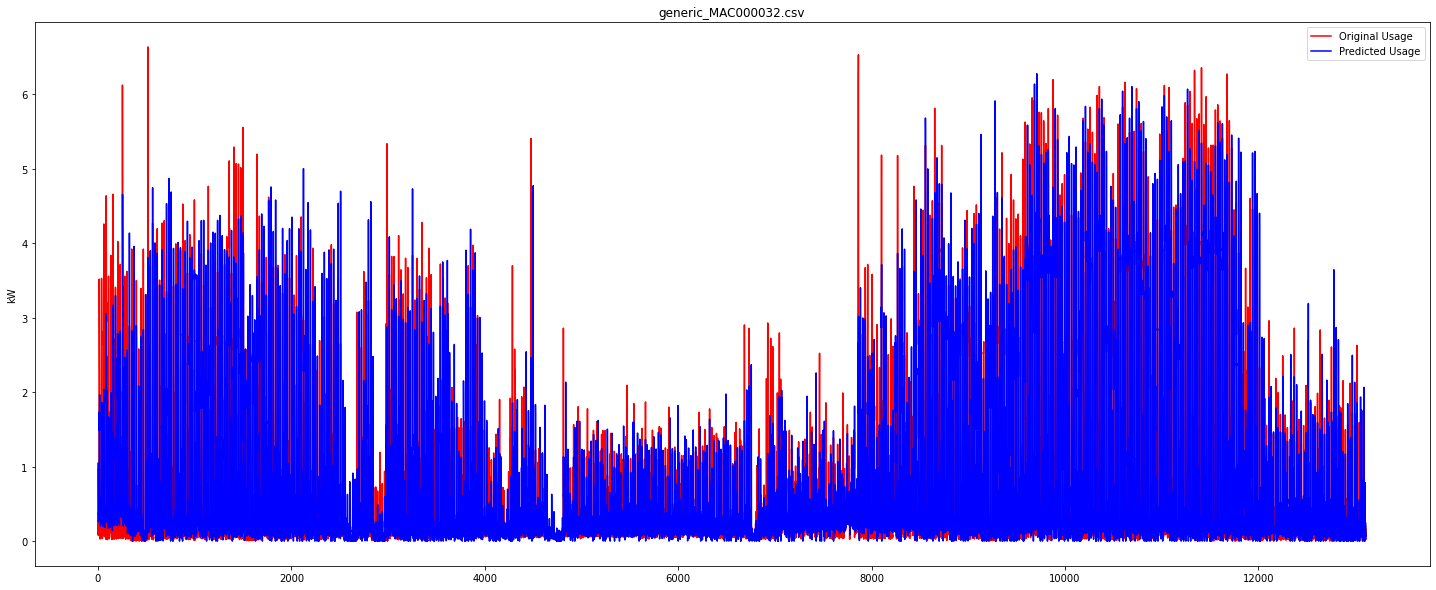

Mean Absolute Percentage Error:  1.949088050263893
Mean Absolute Error:  0.25359460214087576
Max Absolute Error:  [4.6890273]
Mean Squared Error:  0.2222571044808346
---After 1 year---


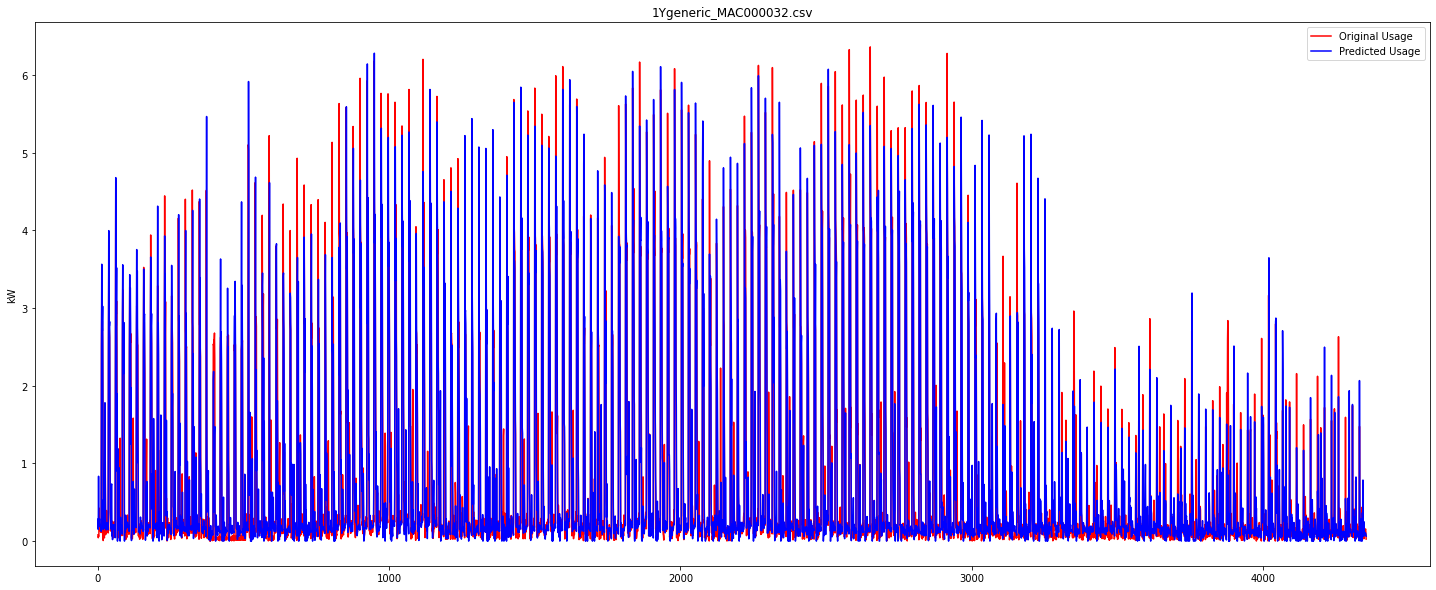

Mean Absolute Percentage Error:  2.3970387778046467
Mean Absolute Error:  0.2562692511409253
Max Absolute Error:  [3.680165]
Mean Squared Error:  0.22154430557787963
------------------SPECIFIC MODEL------------------


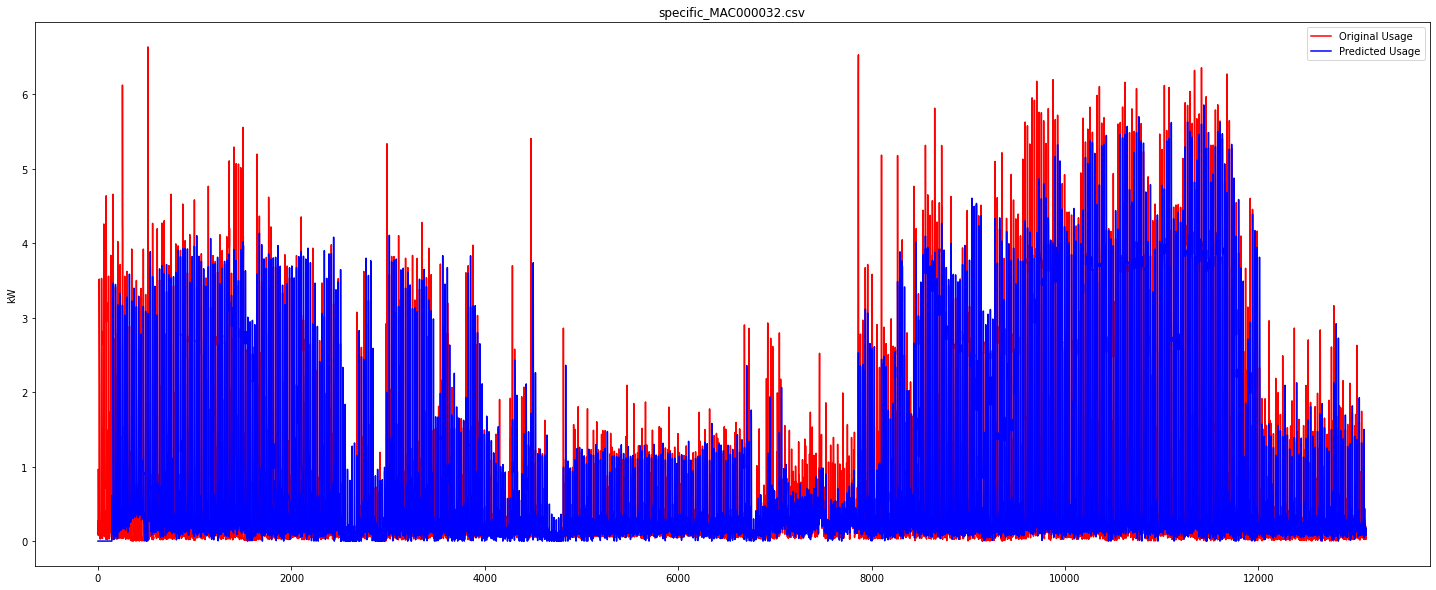

Mean Absolute Percentage Error:  1.8292782149021312
Mean Absolute Error:  0.22197352272916043
Max Absolute Error:  4.6389999999999985
Mean Squared Error:  0.1935881982662811
---After 1 year---


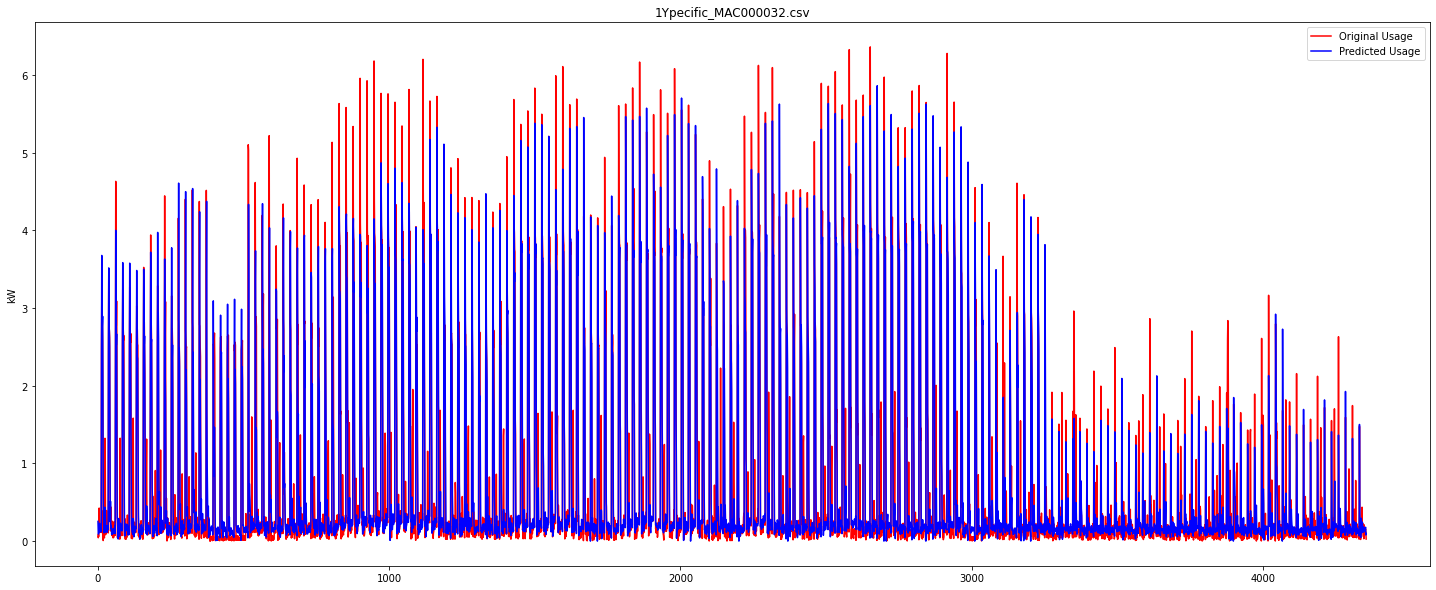

Mean Absolute Percentage Error:  1.9139923909992618
Mean Absolute Error:  0.2080835817382659
Max Absolute Error:  3.0413586230814955
Mean Squared Error:  0.14593726311508445
------------------BEST MODEL------------------
Sub at  240


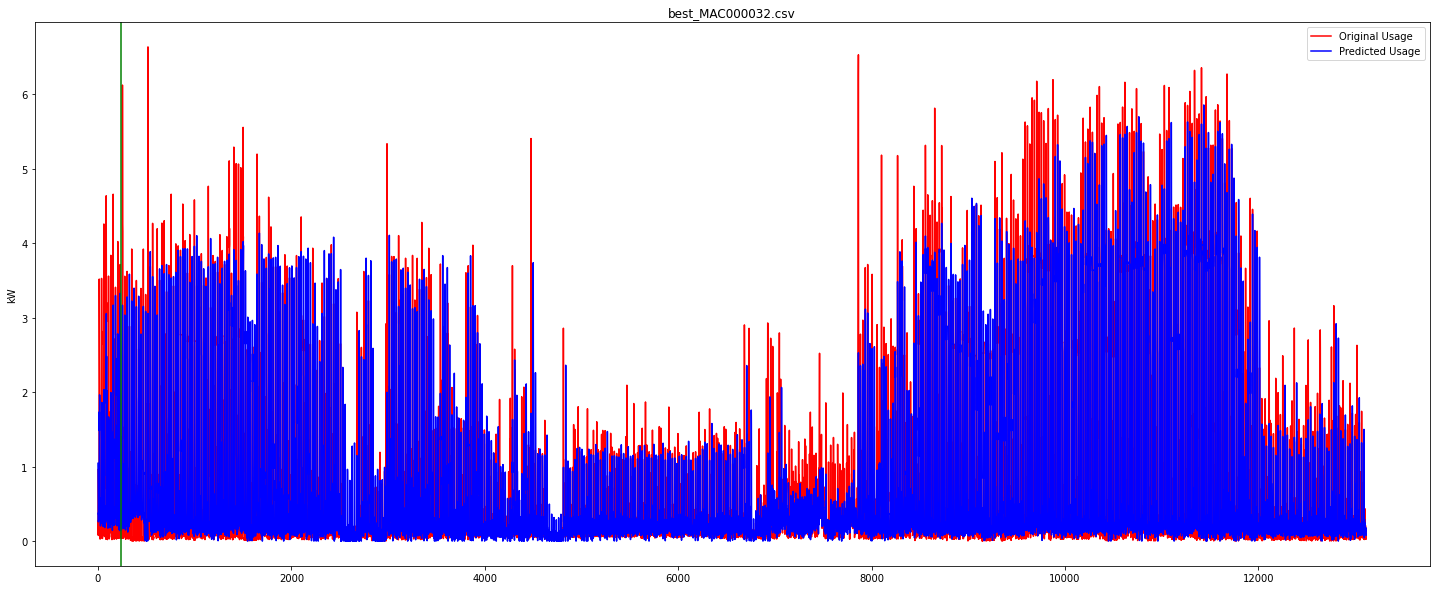

Mean Absolute Percentage Error:  1.8536760712390996
Mean Absolute Error:  0.22065204206270603
Max Absolute Error:  4.088866987461812
Mean Squared Error:  0.18236311249749937
Testing with  MAC000091.csv
------------------GENERIC MODEL------------------


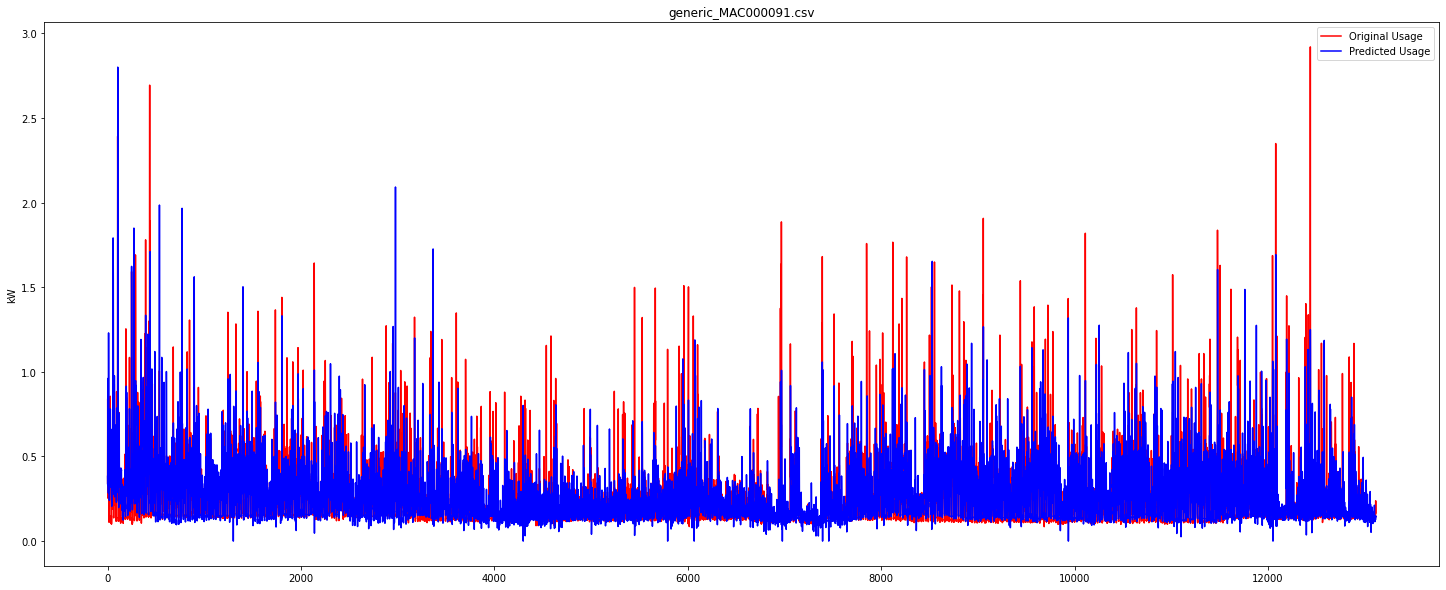

Mean Absolute Percentage Error:  0.3220454574477898
Mean Absolute Error:  0.08959631059254888
Max Absolute Error:  [1.7894826]
Mean Squared Error:  0.027976781278357003
---After 1 year---


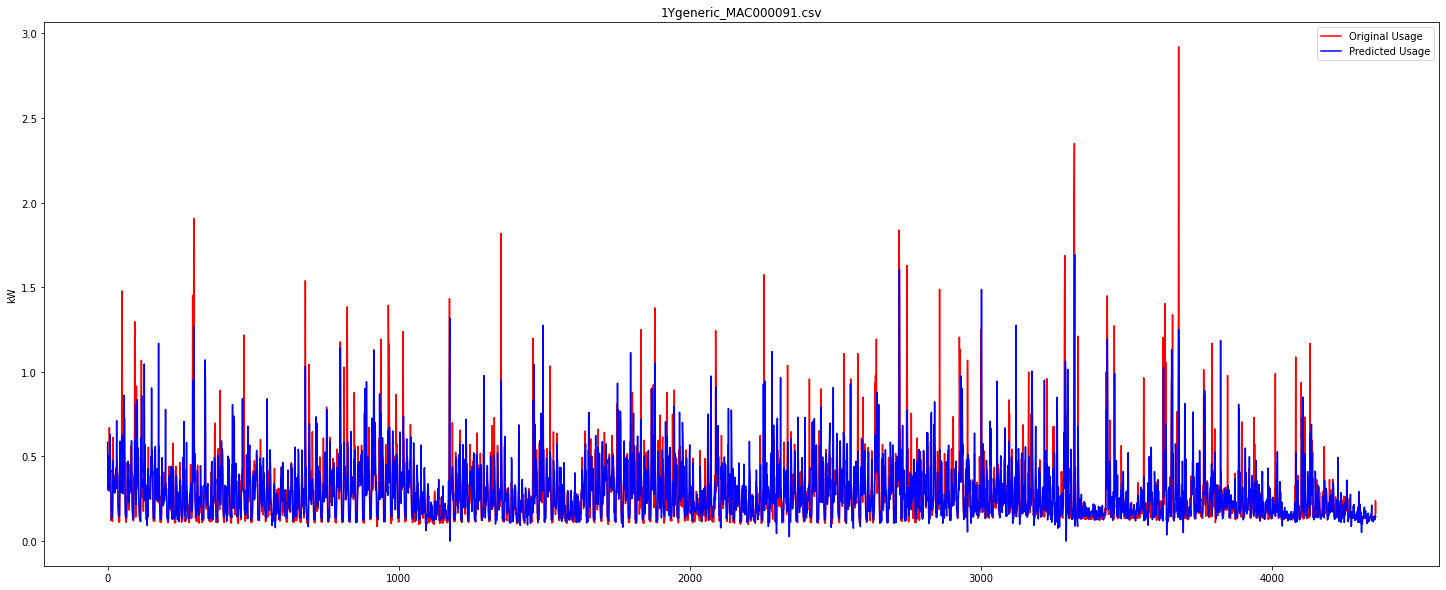

Mean Absolute Percentage Error:  0.323109617788759
Mean Absolute Error:  0.0942550090162093
Max Absolute Error:  [1.7223716]
Mean Squared Error:  0.030236518259125534
------------------SPECIFIC MODEL------------------


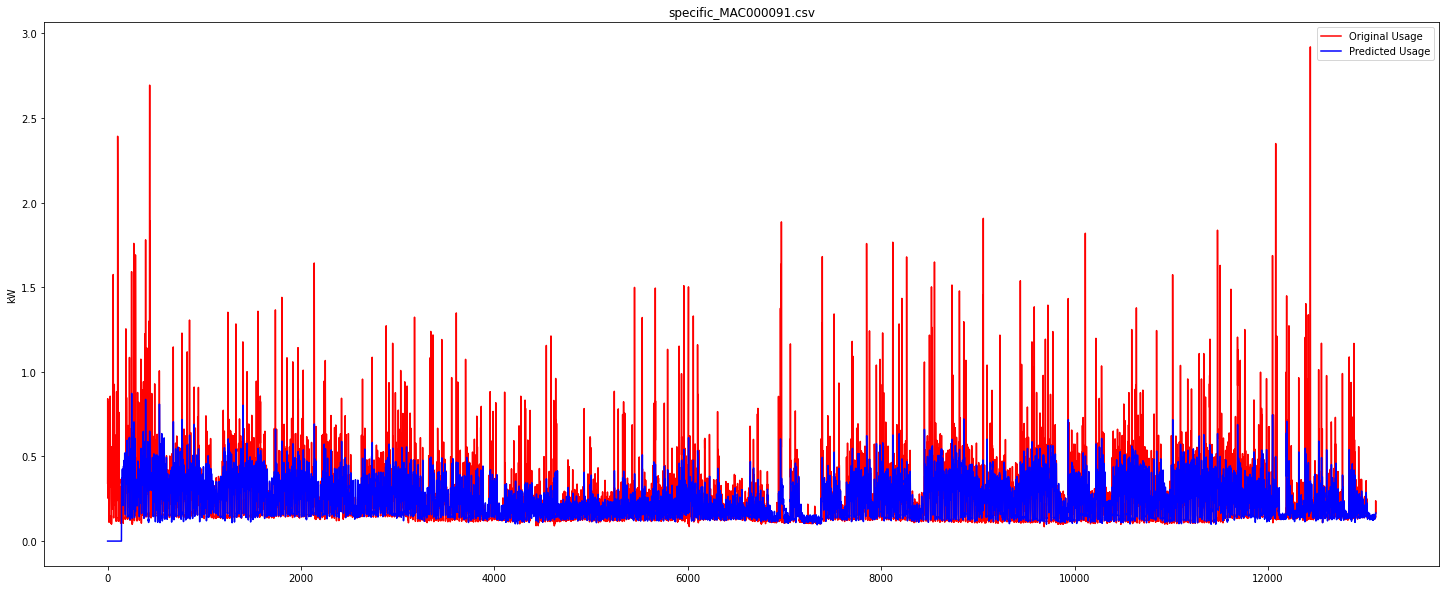

Mean Absolute Percentage Error:  0.24165191534103914
Mean Absolute Error:  0.0753192778381035
Max Absolute Error:  2.5645600413117995
Mean Squared Error:  0.025174918508879852
---After 1 year---


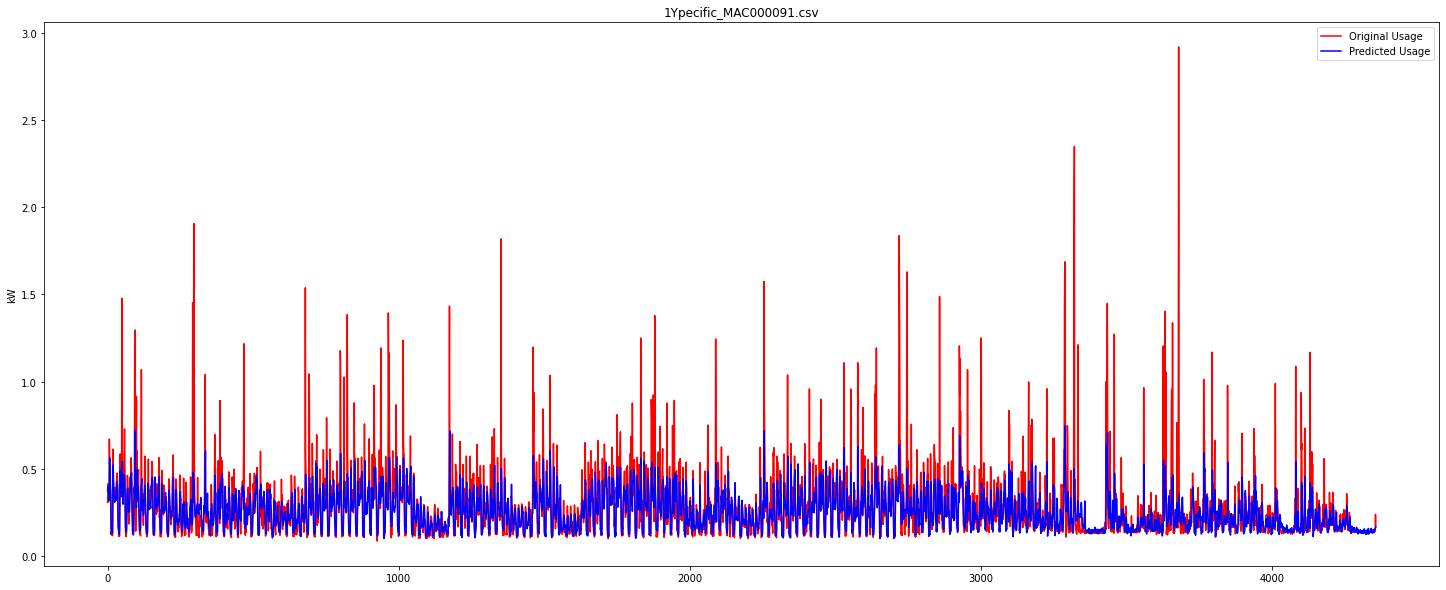

Mean Absolute Percentage Error:  0.22355473388504524
Mean Absolute Error:  0.07337626171276565
Max Absolute Error:  2.5645600413117995
Mean Squared Error:  0.02492114980264421
------------------BEST MODEL------------------
Sub at  268


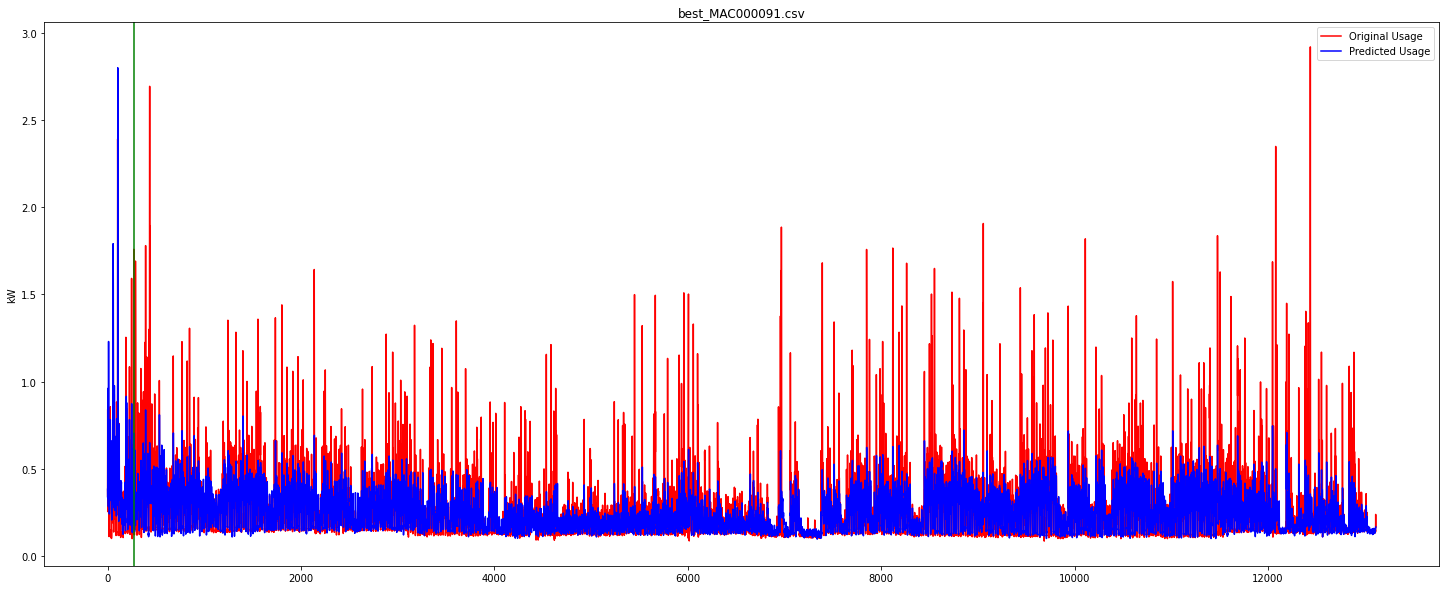

Mean Absolute Percentage Error:  0.23792069805377225
Mean Absolute Error:  0.07299101576558539
Max Absolute Error:  2.5645600413117995
Mean Squared Error:  0.023231663615070806
Testing with  MAC000112.csv
------------------GENERIC MODEL------------------


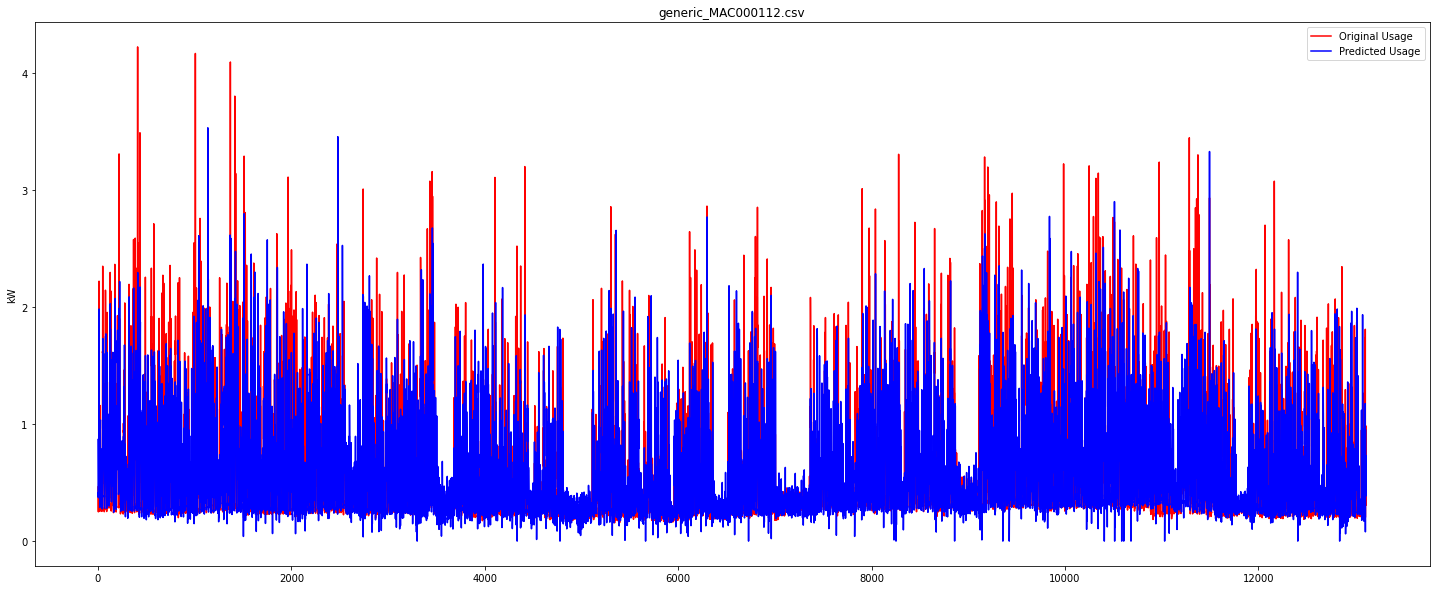

Mean Absolute Percentage Error:  0.4228601542069408
Mean Absolute Error:  0.24198460872521663
Max Absolute Error:  [3.73885]
Mean Squared Error:  0.17440671445072545
---After 1 year---


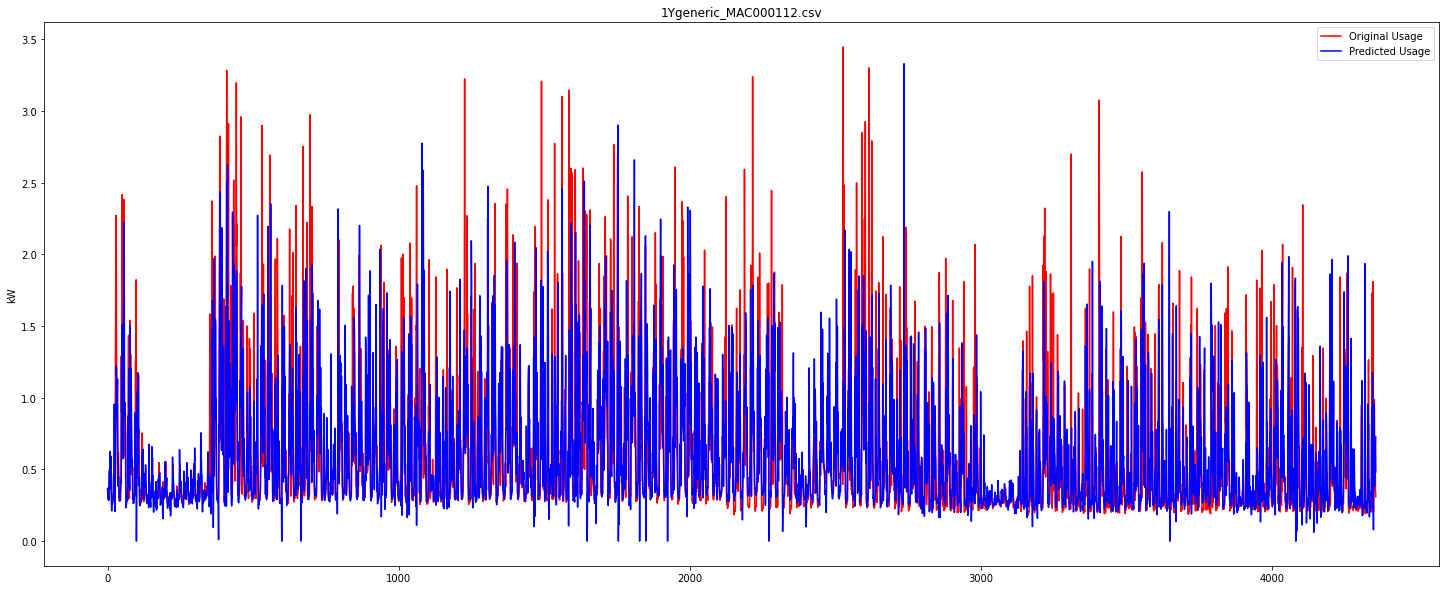

Mean Absolute Percentage Error:  0.4321514313066705
Mean Absolute Error:  0.2641367443835665
Max Absolute Error:  [2.6392825]
Mean Squared Error:  0.1999552712329613
------------------SPECIFIC MODEL------------------


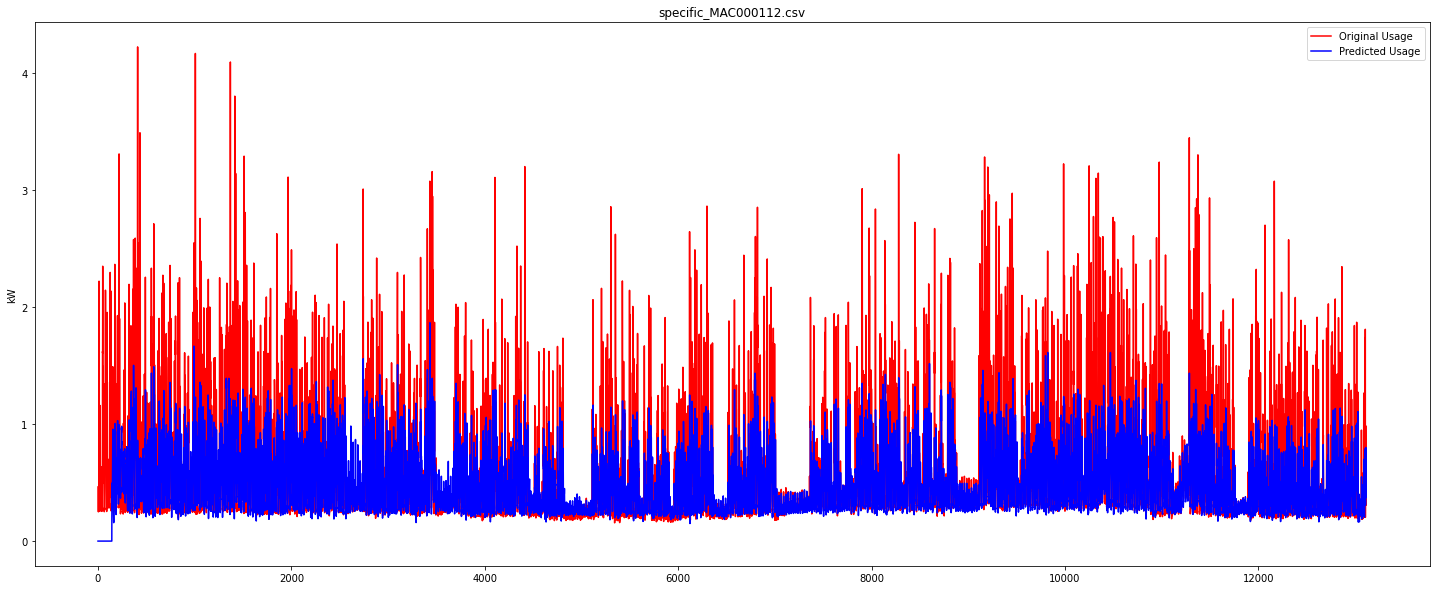

Mean Absolute Percentage Error:  0.3005429455960411
Mean Absolute Error:  0.19580164544337
Max Absolute Error:  3.4464791212709063
Mean Squared Error:  0.13714219281121132
---After 1 year---


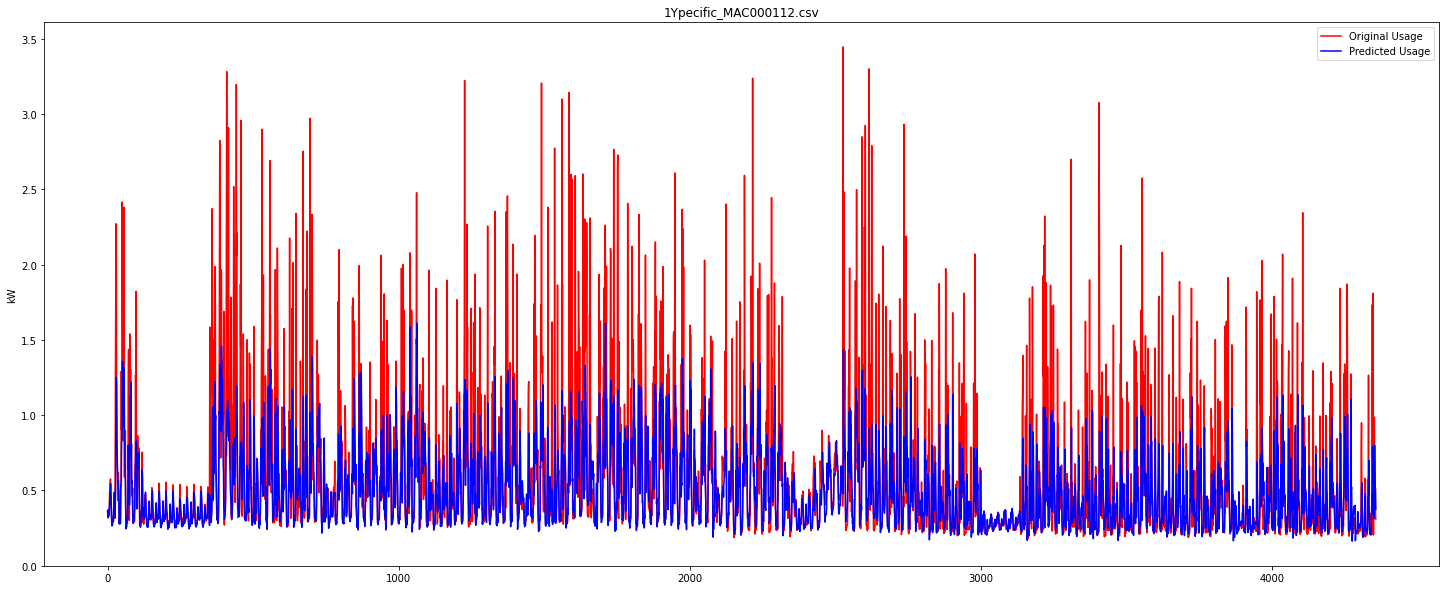

Mean Absolute Percentage Error:  0.2727511057709274
Mean Absolute Error:  0.20098621272124603
Max Absolute Error:  2.854750722279219
Mean Squared Error:  0.1513157796249897
------------------BEST MODEL------------------
Sub at  533


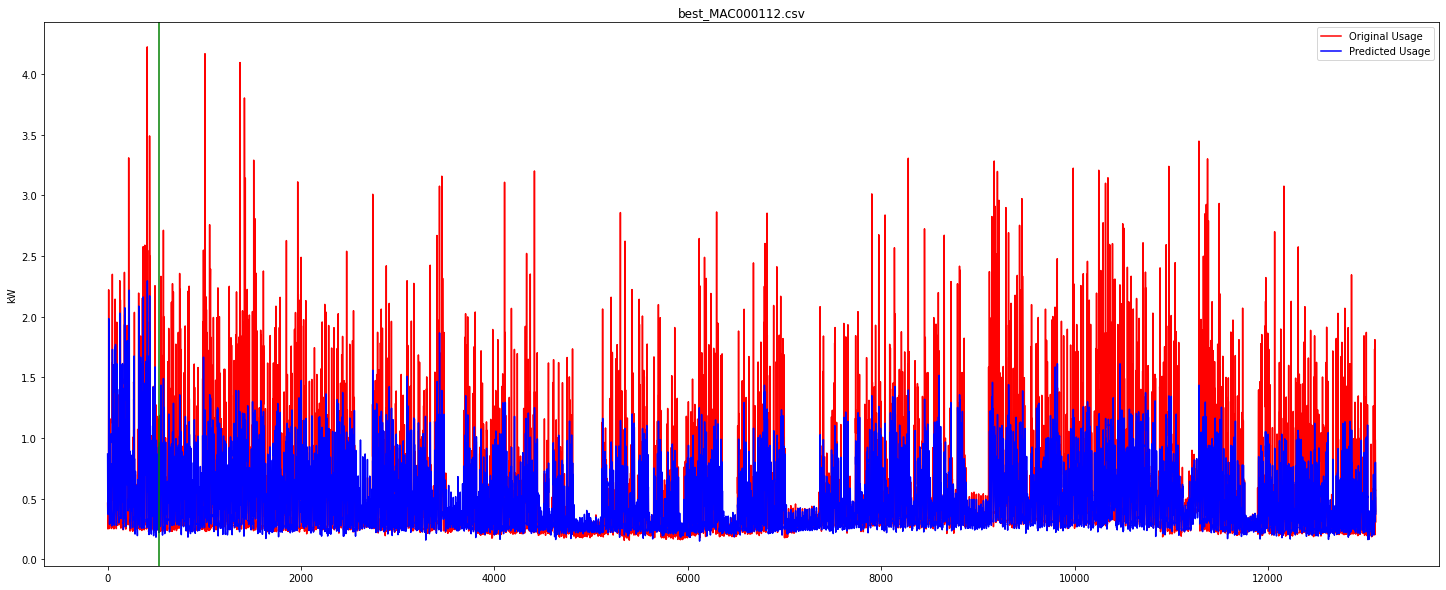

Mean Absolute Percentage Error:  0.2925050533370222
Mean Absolute Error:  0.1900289563627925
Max Absolute Error:  3.4464791212709063
Mean Squared Error:  0.12939020032793214
Testing with  MAC000258.csv
------------------GENERIC MODEL------------------


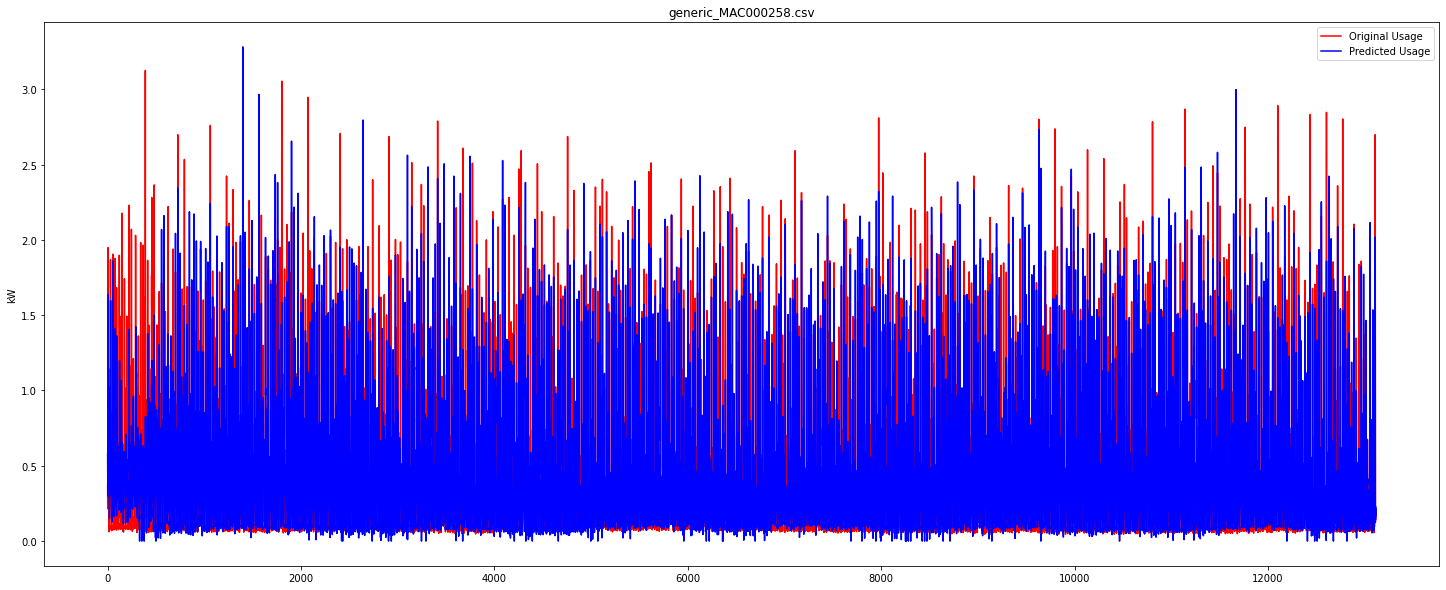

Mean Absolute Percentage Error:  0.46330818453657474
Mean Absolute Error:  0.12411023932029823
Max Absolute Error:  [2.4330103]
Mean Squared Error:  0.053025795981751826
---After 1 year---


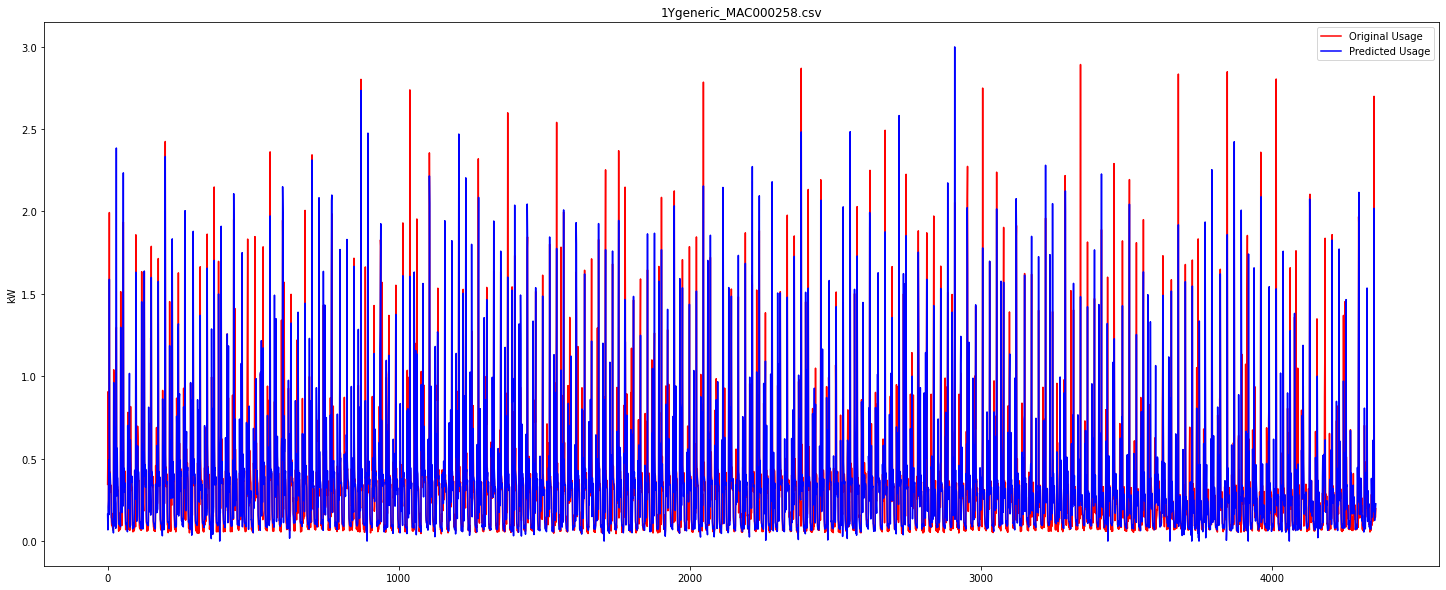

Mean Absolute Percentage Error:  0.42300147020277007
Mean Absolute Error:  0.1132572103116625
Max Absolute Error:  [2.0107465]
Mean Squared Error:  0.04576493750287976
------------------SPECIFIC MODEL------------------


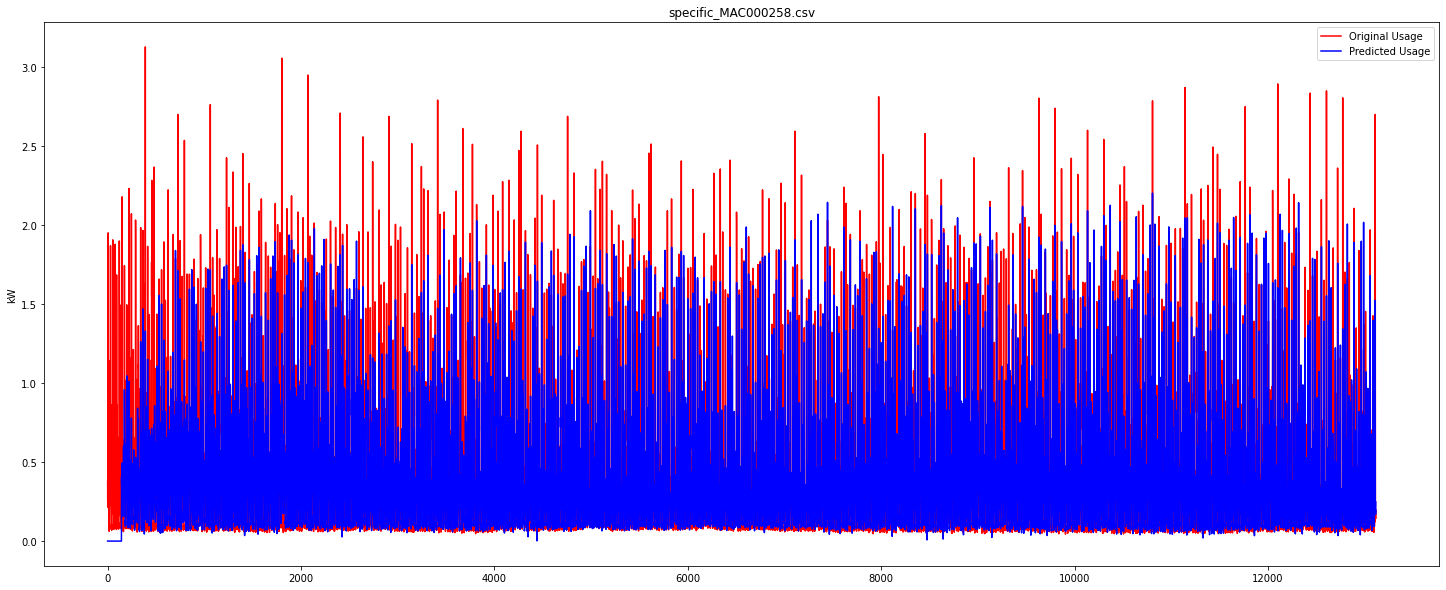

Mean Absolute Percentage Error:  0.3948382483122443
Mean Absolute Error:  0.11117257729062549
Max Absolute Error:  2.3129453443018404
Mean Squared Error:  0.046783147283925526
---After 1 year---


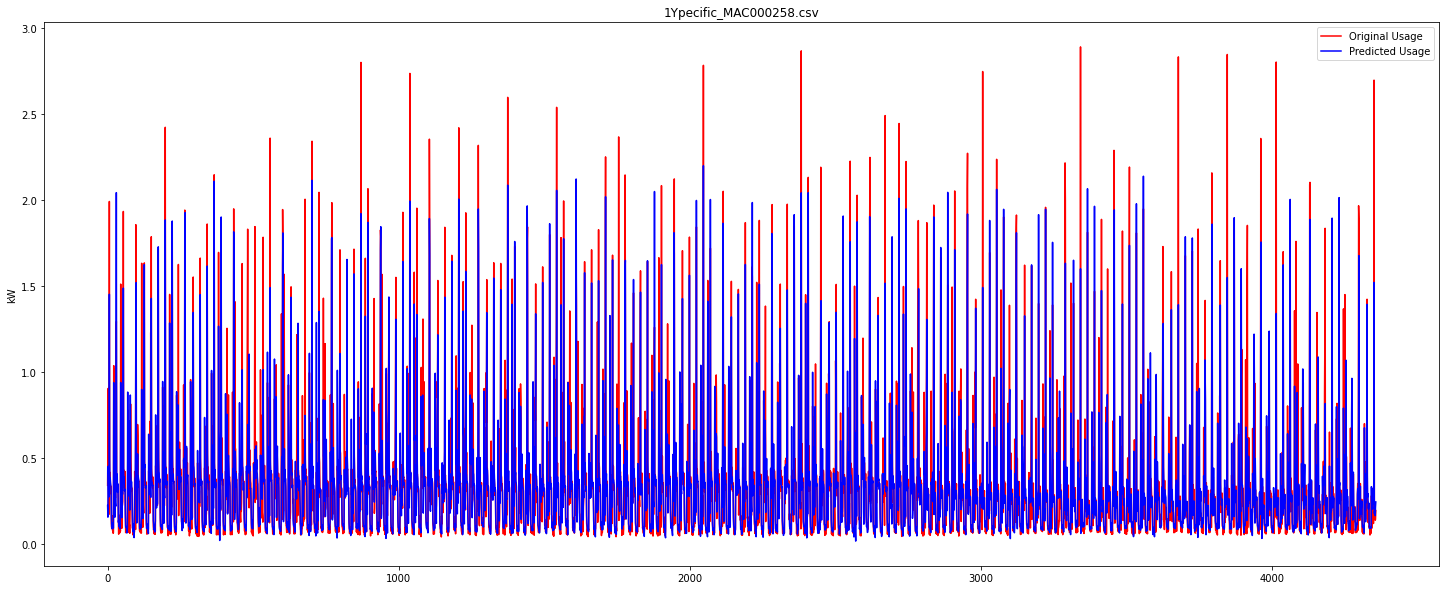

Mean Absolute Percentage Error:  0.38215522693873905
Mean Absolute Error:  0.10202926947985909
Max Absolute Error:  1.8906593819040542
Mean Squared Error:  0.039980918812278006
------------------BEST MODEL------------------
Sub at  240


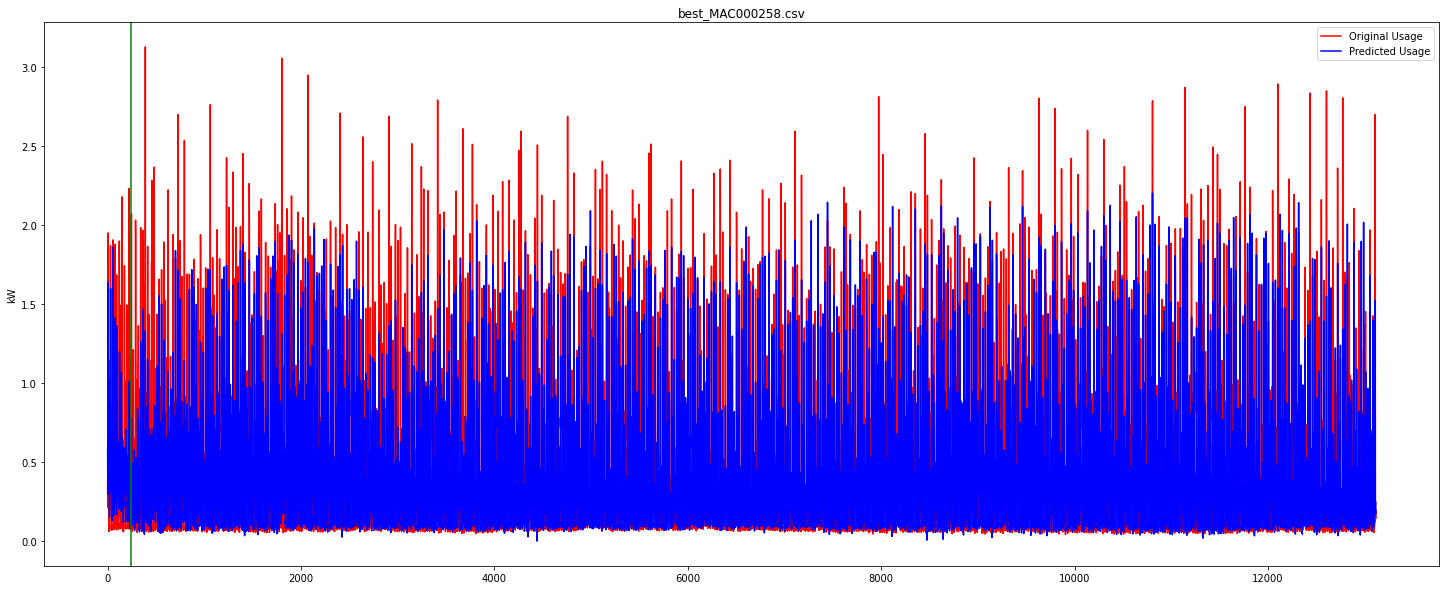

Mean Absolute Percentage Error:  0.3988196950393417
Mean Absolute Error:  0.11029183181537831
Max Absolute Error:  2.3129453443018404
Mean Squared Error:  0.04564014647269395
Testing with  MAC000283.csv


In [ ]:
for filename in testHouses:
    print("Testing with ", filename)
    
    generic_prediction = None
    generic_Model = load_model("generic_Model/Generic_Model.sav")
    generic_preds = []

    specific_prediction = None
    specific_Model = None
    specific_preds = []
    
    best_model = "generic"
    best_preds = []
    
    true = []
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        df = df.iloc[:13140]

        
    specific_x_scaler = StandardScaler()
    specific_y_scaler = StandardScaler()
    
    #new dataframe step by step
    d = {key:[] for key in df.columns}
    userKnownDf = pd.DataFrame(data=d)
        
    hourIndex = 0
    for index, row in df.iterrows():
        hourIndex += 1
        
        #Read new values
        userKnownDf = userKnownDf.append(row)
        if len(userKnownDf) > 24*365:
            userKnownDf = userKnownDf.iloc[1:]
        
        #needs 24h of prior data
        if hourIndex >= 25:
            #generic Model
            x_test = x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
            y_test = [0 for i in range(past_window+1)] #doesnt matter
            test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)

            generic_prediction = y_scaler.inverse_transform(generic_Model.predict(test_generator))[0]
            generic_prediction = generic_prediction if generic_prediction >= 0 else 0
            generic_preds.append(generic_prediction)


            #CHECK LAST PREDICTION
            #get true value
            actualValue = row["use"] if row["use"] != 0 else 0.01
            true.append(actualValue)

            if specific_Model is not None:

                #PREDICT NEXT
                #Specific Model
                #get last past_Window+1 values, the last value will get ignored by time series generator
                x_test = specific_x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
                test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)
                x_test = [arr[0].flatten() for arr in test_generator]

                specific_prediction = specific_y_scaler.inverse_transform(specific_Model.predict(x_test))[0]
                specific_prediction = specific_prediction if specific_prediction >= 0 else 0
                specific_preds.append(specific_prediction)

            if best_model == "generic":
                best_preds.append(generic_prediction)
                #if last 72h accuracy of specific was better
                if specific_Model is not None:
                    if len(specific_preds) >= 24*3:
                        if predict_evaluate(specific_preds[-(3*24):], true[-(3*24):]) < predict_evaluate(generic_preds[-(3*24):], true[-(3*24):]):
                            best_model = "specific"
                            changeX = hourIndex
            else:
                best_preds.append(specific_prediction)
          
        
        #RETRAIN
        if hourIndex % (7*24) == 0:    #Every Week
            x_train = specific_x_scaler.fit_transform(userKnownDf[featuresNames].values)
            y_train = specific_y_scaler.fit_transform(userKnownDf[targetName].values.reshape(-1,1))
            train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=1)
            
            x_train = [arr[0].flatten() for arr in train_generator]
            y_train = [arr[1].flatten() for arr in train_generator]
            
            specific_Model = SVR(kernel = "rbf")
            specific_Model.fit(x_train, y_train)
            
            #------------------------------
            x_train = x_scaler.transform(userKnownDf[featuresNames].values)
            y_train = y_scaler.transform(userKnownDf[targetName].values.reshape(-1,1))

            #Time series
            train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=64)
            train(generic_Model, train_generator)
        
        a = str(hourIndex) + "/" + str(len(df))
        print(a, end="\r")
    
    print("------------------GENERIC MODEL------------------")
    a = predict_evaluate(generic_preds, true, showplots=True, graphName = "generic_" + filename)
    print("---After 1 year---")
    a = predict_evaluate(generic_preds[365*24:], true[365*24:], showplots=True, graphName = "1Ygeneric_" + filename)
    

    print("------------------SPECIFIC MODEL------------------")
    specific_preds = [0 for i in range(len(true) - len(specific_preds))] + specific_preds
    a = predict_evaluate(specific_preds, true, showplots=True, graphName = "specific_" + filename)
    print("---After 1 year---")
    a = predict_evaluate(specific_preds[365*24:], true[365*24:], showplots=True, graphName = "1Ypecific_" + filename)
    
    
    print("------------------BEST MODEL------------------")
    print("Sub at ", changeX)
    a = predict_evaluate(best_preds, true, showplots=True, verticalX =changeX, graphName = "best_" + filename)
            

Testing with  MAC000283.csv
------------------GENERIC MODEL------------------


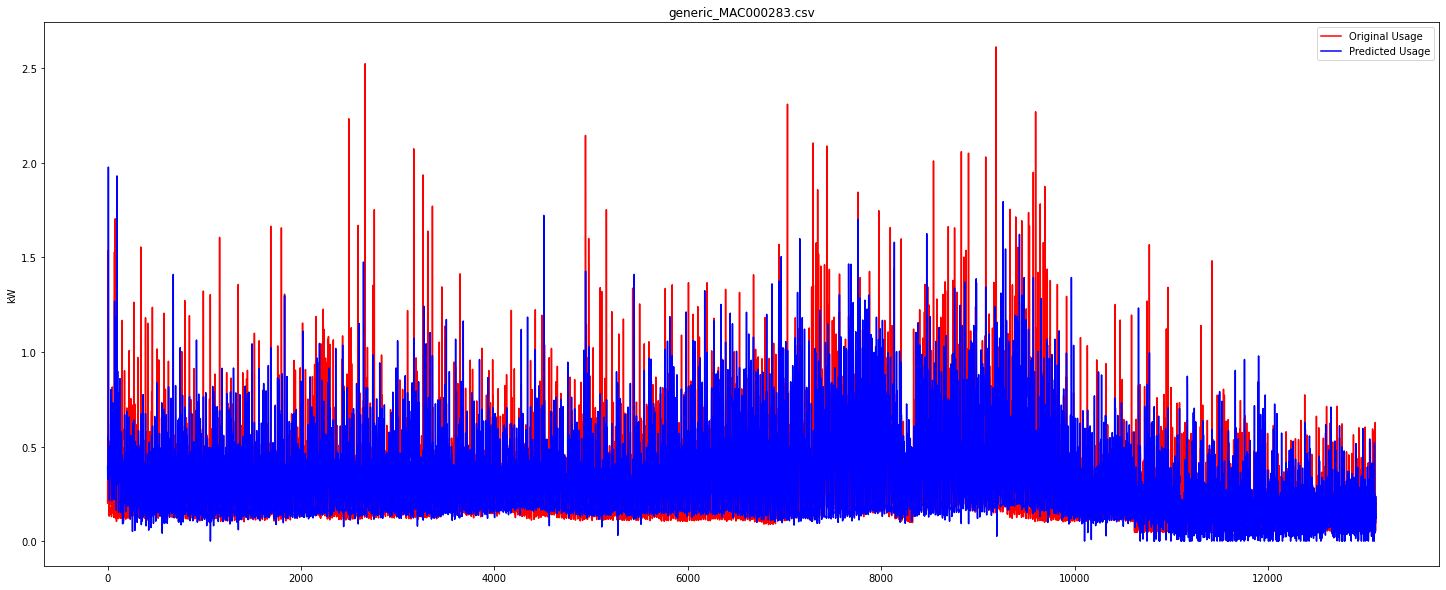

Mean Absolute Percentage Error:  0.4249779532419864
Mean Absolute Error:  0.11297363706232341
Max Absolute Error:  [2.109331]
Mean Squared Error:  0.037000046330494994
---After 1 year---


<Figure size 432x288 with 0 Axes>

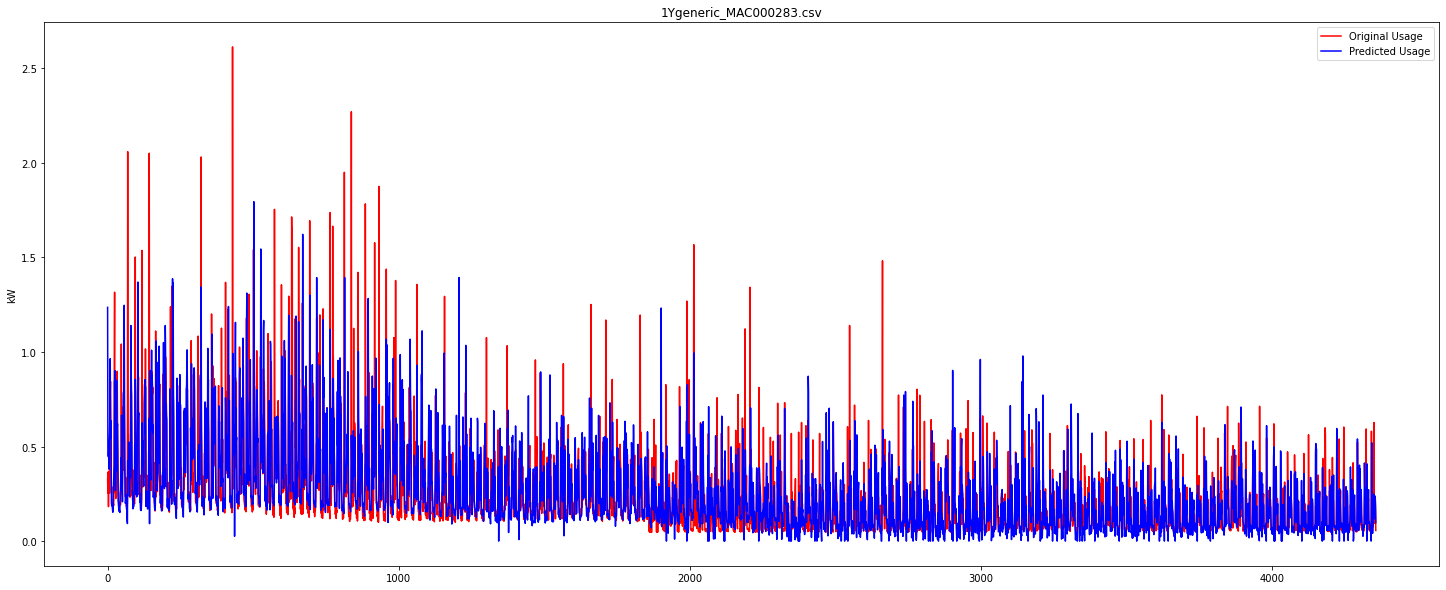

Mean Absolute Percentage Error:  0.6198981066437238
Mean Absolute Error:  0.11836356010604758
Max Absolute Error:  [2.109331]
Mean Squared Error:  0.03961049738949419
------------------SPECIFIC MODEL------------------


<Figure size 432x288 with 0 Axes>

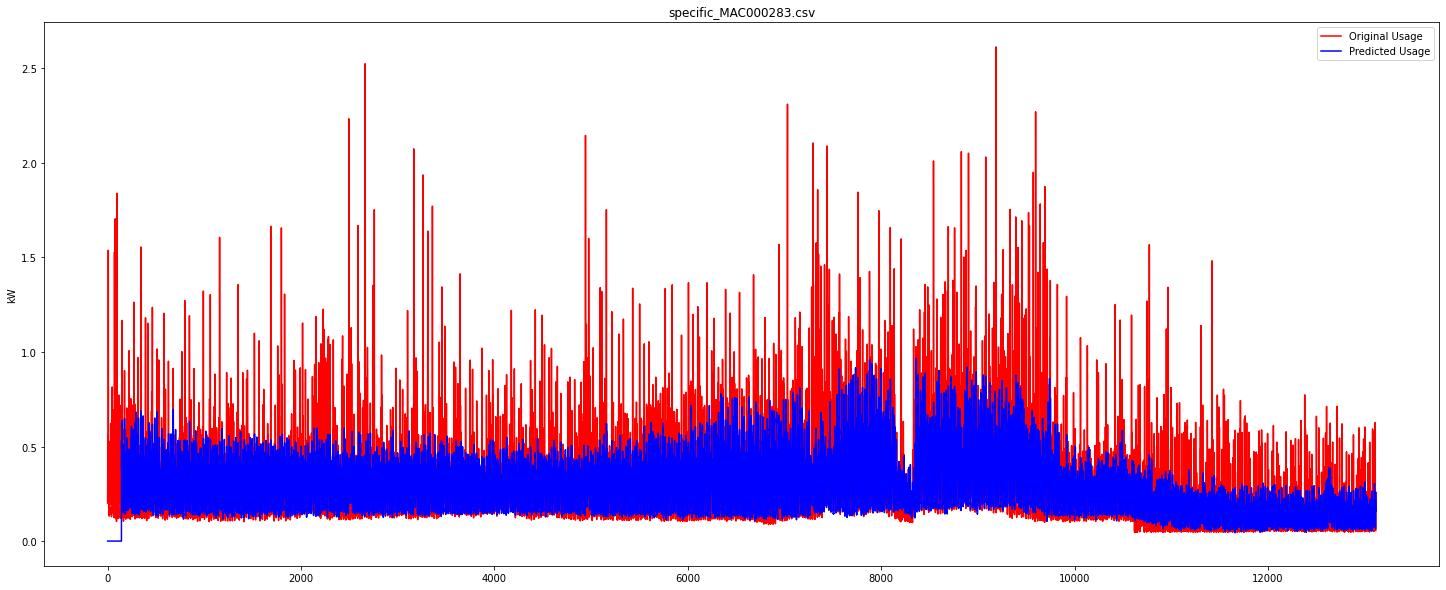

Mean Absolute Percentage Error:  0.304900688385712
Mean Absolute Error:  0.09092473978501484
Max Absolute Error:  2.068147946014795
Mean Squared Error:  0.028948950263106035
---After 1 year---


<Figure size 432x288 with 0 Axes>

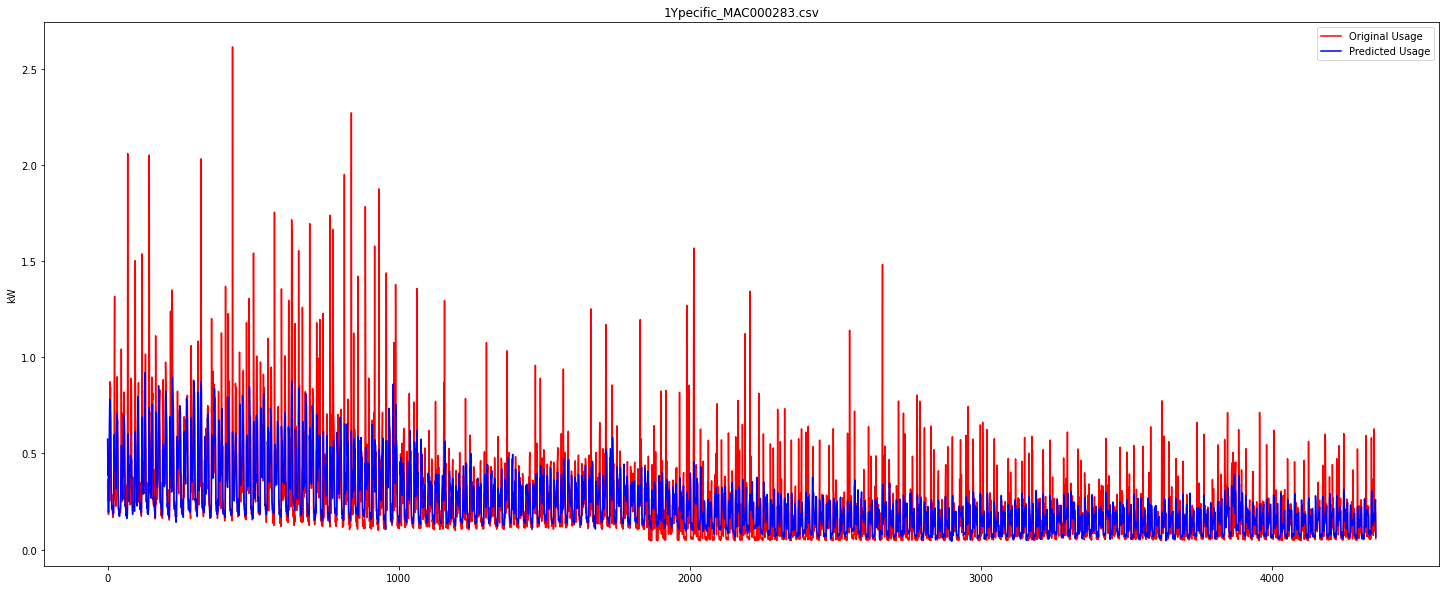

Mean Absolute Percentage Error:  0.4111884674294183
Mean Absolute Error:  0.08700270308744552
Max Absolute Error:  2.00123630413479
Mean Squared Error:  0.02729763657374205
------------------BEST MODEL------------------
Sub at  240


<Figure size 432x288 with 0 Axes>

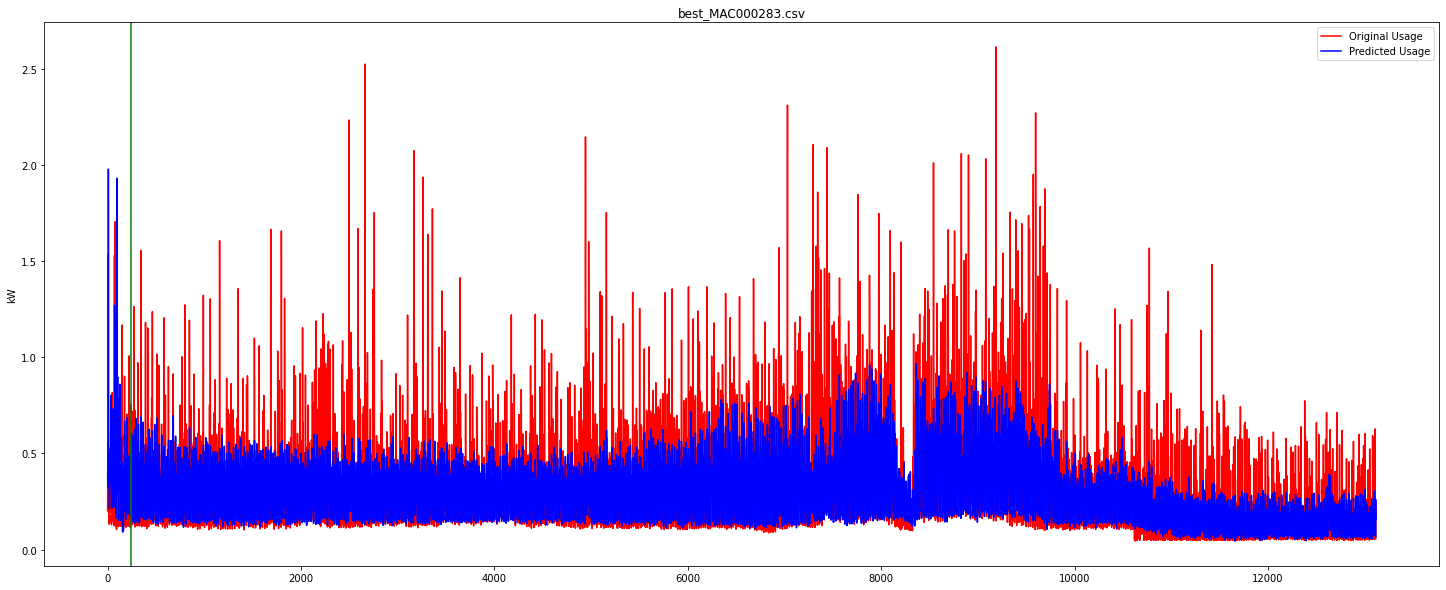

Mean Absolute Percentage Error:  0.3021890673765874
Mean Absolute Error:  0.08944846899188781
Max Absolute Error:  2.068147946014795
Mean Squared Error:  0.027892274686160637


<Figure size 432x288 with 0 Axes>

In [8]:
for filename in testHouses:
    print("Testing with ", filename)
    
    generic_prediction = None
    generic_Model = load_model("generic_Model/Generic_Model.sav")
    generic_preds = []

    specific_prediction = None
    specific_Model = None
    specific_preds = []
    
    best_model = "generic"
    best_preds = []
    
    true = []
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        df = df.iloc[:13140]

        
    specific_x_scaler = StandardScaler()
    specific_y_scaler = StandardScaler()
    
    #new dataframe step by step
    d = {key:[] for key in df.columns}
    userKnownDf = pd.DataFrame(data=d)
        
    hourIndex = 0
    for index, row in df.iterrows():
        hourIndex += 1
        
        #Read new values
        userKnownDf = userKnownDf.append(row)
        if len(userKnownDf) > 24*365:
            userKnownDf = userKnownDf.iloc[1:]
        
        #needs 24h of prior data
        if hourIndex >= 25:
            #generic Model
            x_test = x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
            y_test = [0 for i in range(past_window+1)] #doesnt matter
            test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)

            generic_prediction = y_scaler.inverse_transform(generic_Model.predict(test_generator))[0]
            generic_prediction = generic_prediction if generic_prediction >= 0 else 0
            generic_preds.append(generic_prediction)


            #CHECK LAST PREDICTION
            #get true value
            actualValue = row["use"] if row["use"] != 0 else 0.01
            true.append(actualValue)

            if specific_Model is not None:

                #PREDICT NEXT
                #Specific Model
                #get last past_Window+1 values, the last value will get ignored by time series generator
                x_test = specific_x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
                test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)
                x_test = [arr[0].flatten() for arr in test_generator]

                specific_prediction = specific_y_scaler.inverse_transform(specific_Model.predict(x_test))[0]
                specific_prediction = specific_prediction if specific_prediction >= 0 else 0
                specific_preds.append(specific_prediction)

            if best_model == "generic":
                best_preds.append(generic_prediction)
                #if last 72h accuracy of specific was better
                if specific_Model is not None:
                    if len(specific_preds) >= 24*3:
                        if predict_evaluate(specific_preds[-(3*24):], true[-(3*24):]) < predict_evaluate(generic_preds[-(3*24):], true[-(3*24):]):
                            best_model = "specific"
                            changeX = hourIndex
            else:
                best_preds.append(specific_prediction)
          
        
        #RETRAIN
        if hourIndex % (7*24) == 0:    #Every Week
            x_train = specific_x_scaler.fit_transform(userKnownDf[featuresNames].values)
            y_train = specific_y_scaler.fit_transform(userKnownDf[targetName].values.reshape(-1,1))
            train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=1)
            
            x_train = [arr[0].flatten() for arr in train_generator]
            y_train = [arr[1].flatten() for arr in train_generator]
            
            specific_Model = SVR(kernel = "rbf")
            specific_Model.fit(x_train, y_train)
            
            #------------------------------
            x_train = x_scaler.transform(userKnownDf[featuresNames].values)
            y_train = y_scaler.transform(userKnownDf[targetName].values.reshape(-1,1))

            #Time series
            train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=64)
            train(generic_Model, train_generator)
        
        a = str(hourIndex) + "/" + str(len(df))
        print(a, end="\r")
    
    print("------------------GENERIC MODEL------------------")
    a = predict_evaluate(generic_preds, true, showplots=True, graphName = "generic_" + filename)
    print("---After 1 year---")
    a = predict_evaluate(generic_preds[365*24:], true[365*24:], showplots=True, graphName = "1Ygeneric_" + filename)
    

    print("------------------SPECIFIC MODEL------------------")
    specific_preds = [0 for i in range(len(true) - len(specific_preds))] + specific_preds
    a = predict_evaluate(specific_preds, true, showplots=True, graphName = "specific_" + filename)
    print("---After 1 year---")
    a = predict_evaluate(specific_preds[365*24:], true[365*24:], showplots=True, graphName = "1Ypecific_" + filename)
    
    
    print("------------------BEST MODEL------------------")
    print("Sub at ", changeX)
    a = predict_evaluate(best_preds, true, showplots=True, verticalX =changeX, graphName = "best_" + filename)

In [ ]:
for filename in testHouses:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    features = df[featuresNames].values[-(24*30-past_window):]
    target = df[targetName].values[-(24*30-past_window):]

    #SCALE
    x_test = x_scaler.transform(features)
    y_test = y_scaler.transform(target)

    #Time series
    batch_size=64
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)

    prediction = generic_Model.predict(test_generator).reshape(-1, 1)

    prediction = y_scaler.inverse_transform(prediction)


    predict_evaluate(prediction, target[past_window:], showplots=True)